Initial full dataset size: (431371, 79)
Size after removing missing values/duplicates: (426322, 79)
Training set size: (121676, 79) | Test set size: (304646, 79)
Training set (only normal) size: (45101, 79)
Test set size after under-sampling: (99698, 79)
Label
Benign           49849
DrDoS_NTP        23817
TFTP             19386
DrDoS_UDP         1979
UDP-lag           1750
DrDoS_MSSQL       1154
DrDoS_DNS          720
DrDoS_SNMP         549
DrDoS_LDAP         254
DrDoS_NetBIOS      133
Syn                 98
WebDDoS              9
Name: count, dtype: int64
train_tensors shape: torch.Size([45101, 77])
test_tensors  shape: torch.Size([99698, 77])
Using device: cuda
Epoch [1/50], Loss: 0.439986
Epoch [2/50], Loss: 0.173104
Epoch [3/50], Loss: 0.087240
Epoch [4/50], Loss: 0.059261
Epoch [5/50], Loss: 0.056520
Epoch [6/50], Loss: 0.049641
Epoch [7/50], Loss: 0.128498
Epoch [8/50], Loss: 0.047971
Epoch [9/50], Loss: 0.081265
Epoch [10/50], Loss: 0.059976
Epoch [11/50], Loss: 0.085247
Epoch [

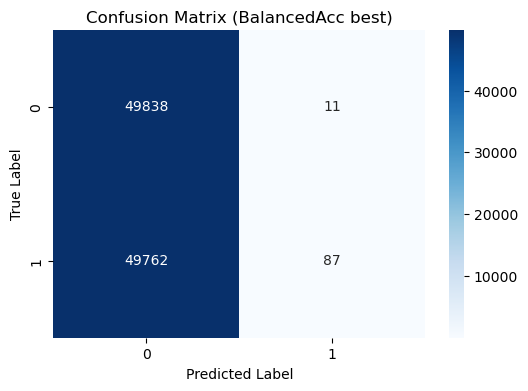

Macro F1 (BalancedAcc best): 0.3352

Classification Report (BalancedAcc best):
              precision    recall  f1-score   support

   Normal(0)       0.50      1.00      0.67     49849
   Attack(1)       0.89      0.00      0.00     49849

    accuracy                           0.50     99698
   macro avg       0.69      0.50      0.34     99698
weighted avg       0.69      0.50      0.34     99698


[Business Constraints] No threshold satisfies the desired TPR>=30.0%, FPR<=30.0%

===== Summary =====
 - Balanced Accuracy threshold  : 142.66383
 - Biz constraints threshold    : None found under given TPR/FPR
 - Balanced Accuracy            : 0.5008
 - Macro F1 (BalancedAcc best)  : 0.3352
 - Final FPR (Biz)              : N/A
 - Final TPR (Biz)              : N/A
 - Macro F1 (Biz)               : N/A


In [1]:
import glob
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score  # added (for Macro F1 calculation)
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

########################
# 1) Load Data         #
########################
train_files = glob.glob("../data/*training.parquet")
test_files  = glob.glob("../data/*testing.parquet")

df_list = []
for f in train_files:
    temp = pd.read_parquet(f)
    temp['set_type'] = 'train'
    df_list.append(temp)
for f in test_files:
    temp = pd.read_parquet(f)
    temp['set_type'] = 'test'
    df_list.append(temp)

df_all = pd.concat(df_list, ignore_index=True)
print("Initial full dataset size:", df_all.shape)

##############################
# 2) Remove Missing Values & Duplicates     #
##############################
df_all.dropna(inplace=True)
df_all.drop_duplicates(inplace=True)
print("Size after removing missing values/duplicates:", df_all.shape)

###############################
# 3) Split Training/Testing Sets    #
###############################
df_train_raw = df_all[df_all['set_type'] == 'train'].copy()
df_test_raw  = df_all[df_all['set_type'] == 'test'].copy()

print("Training set size:", df_train_raw.shape, "| Test set size:", df_test_raw.shape)

# (3-0) The autoencoder is trained only on normal (Benign) data
df_train_raw = df_train_raw[df_train_raw['Label'] == 'Benign'].copy()
print("Training set (only normal) size:", df_train_raw.shape)

# (3-1) Under-sample the test set (balance Normal vs. Attack)
normal_test = df_test_raw[df_test_raw['Label'] == 'Benign']
attack_test = df_test_raw[df_test_raw['Label'] != 'Benign']

num_normal = len(normal_test)
num_attack = len(attack_test)
min_count  = min(num_normal, num_attack)

normal_sample = normal_test.sample(n=min_count, random_state=42)
attack_sample = attack_test.sample(n=min_count, random_state=42)

df_test_raw = pd.concat([normal_sample, attack_sample], ignore_index=True)
print("Test set size after under-sampling:", df_test_raw.shape)
print(df_test_raw['Label'].value_counts())

drop_cols = ['Label', 'set_type']
feature_cols = [c for c in df_train_raw.columns if c not in drop_cols]

##################
# 4) Scaling     #
##################
scaler = StandardScaler()

train_values = scaler.fit_transform(df_train_raw[feature_cols])
test_values  = scaler.transform(df_test_raw[feature_cols])

train_tensors = torch.tensor(train_values, dtype=torch.float32)
test_tensors  = torch.tensor(test_values,  dtype=torch.float32)

print("train_tensors shape:", train_tensors.shape)
print("test_tensors  shape:", test_tensors.shape)

########################
# 5) Define/Train Model #
########################
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

input_dim = len(feature_cols)
model = Autoencoder(input_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_dataset = torch.utils.data.TensorDataset(train_tensors)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=256, 
                                           shuffle=True)

epochs = 50
model.train()

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for batch_data, in train_loader:
        batch_data = batch_data.to(device)
        reconstructed = model(batch_data)
        loss = criterion(reconstructed, batch_data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * len(batch_data)
    
    avg_loss = epoch_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

########################
# 6) Testing (Compute Reconstruction Error)  #
########################
model.eval()

with torch.no_grad():
    test_tensors_device = test_tensors.to(device)
    reconstruction = model(test_tensors_device)
    mse = torch.mean((reconstruction - test_tensors_device)**2, dim=1)
    mse = mse.detach().cpu().numpy()

df_test_raw['recon_error'] = mse

##############################
# (A) Search for Optimal Threshold based on Basic Balanced Accuracy
##############################
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

y_true = (df_test_raw['Label'] != 'Benign') 
err_min = df_test_raw['recon_error'].min()
err_max = df_test_raw['recon_error'].max()
threshold_candidates = np.linspace(err_min, err_max, 100)

best_thr = None
best_balacc = 0.0

for t in threshold_candidates:
    y_pred_temp = df_test_raw['recon_error'] > t
    score = balanced_accuracy_score(y_true, y_pred_temp)
    if score > best_balacc:
        best_balacc = score
        best_thr = t

print(f"Best threshold (BalancedAcc): {best_thr:.5f}, BalancedAcc: {best_balacc:.4f}")

##############################
# (B) Final Prediction - Based on BalancedAcc
##############################
df_test_raw['predict_isAttack_balacc'] = df_test_raw['recon_error'] > best_thr

cm_balacc = confusion_matrix(y_true, df_test_raw['predict_isAttack_balacc'])
final_balacc = balanced_accuracy_score(y_true, df_test_raw['predict_isAttack_balacc'])

print("\nConfusion Matrix (BalancedAcc best):\n", cm_balacc)
print(f"Final Balanced Accuracy: {final_balacc:.4f}")

# Visualize the confusion matrix as an image
plt.figure(figsize=(6,4))
sns.heatmap(cm_balacc, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix (BalancedAcc best)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Calculate Macro F1
macro_f1_balacc = f1_score(y_true, df_test_raw['predict_isAttack_balacc'], average='macro')
print(f"Macro F1 (BalancedAcc best): {macro_f1_balacc:.4f}")

print("\nClassification Report (BalancedAcc best):")
print(classification_report(y_true, 
                            df_test_raw['predict_isAttack_balacc'],
                            target_names=['Normal(0)','Attack(1)']))

##############################
# (C) Search based on Business/Security Constraints
##############################
desired_tpr = 0.30
desired_fpr = 0.30

feasible_thresholds = []
for t in threshold_candidates:
    y_pred_temp = (df_test_raw['recon_error'] > t)
    cm_temp = confusion_matrix(y_true, y_pred_temp, labels=[False, True])
    # cm_temp = [[TN, FP],
    #            [FN, TP]]
    TN, FP = cm_temp[0,0], cm_temp[0,1]
    FN, TP = cm_temp[1,0], cm_temp[1,1]

    total_normal = TN + FP
    total_attack = TP + FN

    if total_normal > 0:
        curr_fpr = FP / total_normal
    else:
        curr_fpr = 1.0

    if total_attack > 0:
        curr_tpr = TP / total_attack
    else:
        curr_tpr = 0.0

    if (curr_tpr >= desired_tpr) and (curr_fpr <= desired_fpr):
        feasible_thresholds.append(t)

if len(feasible_thresholds) == 0:
    print(f"\n[Business Constraints] No threshold satisfies the desired TPR>={desired_tpr*100}%, FPR<={desired_fpr*100}%")
else:
    chosen_thr = min(feasible_thresholds)  # Minimum threshold among those that meet the condition
    print(f"\n[Business Constraints] Number of threshold candidates meeting the desired conditions: {len(feasible_thresholds)}")
    print(f"Chosen threshold: {chosen_thr:.5f}")

    df_test_raw['predict_isAttack_biz'] = (df_test_raw['recon_error'] > chosen_thr)

    cm_biz = confusion_matrix(y_true, df_test_raw['predict_isAttack_biz'], labels=[False, True])
    TN, FP = cm_biz[0,0], cm_biz[0,1]
    FN, TP = cm_biz[1,0], cm_biz[1,1]
    final_fpr = FP / (FP + TN)
    final_tpr = TP / (TP + FN)

    print("\nConfusion Matrix (Biz constraints):\n", cm_biz)
    print(f"Final FPR: {final_fpr*100:.2f}%, TPR: {final_tpr*100:.2f}%")

    # Visualize the confusion matrix as an image
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_biz, annot=True, cmap='Reds', fmt='g')
    plt.title("Confusion Matrix (Biz constraints)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Calculate Macro F1
    macro_f1_biz = f1_score(y_true, df_test_raw['predict_isAttack_biz'], average='macro')
    print(f"Macro F1 (Biz constraints): {macro_f1_biz:.4f}")

    print("\nClassification Report (Biz constraints):")
    print(classification_report(y_true, 
                                df_test_raw['predict_isAttack_biz'],
                                target_names=['Normal(0)','Attack(1)']))

##########################
# (D) Summary
##########################
print("\n===== Summary =====")
print(f" - Balanced Accuracy threshold  : {best_thr:.5f}")
if len(feasible_thresholds) > 0:
    print(f" - Biz constraints threshold    : {chosen_thr:.5f}")
else:
    print(" - Biz constraints threshold    : None found under given TPR/FPR")

print(f" - Balanced Accuracy            : {final_balacc:.4f}")
print(f" - Macro F1 (BalancedAcc best)  : {macro_f1_balacc:.4f}")

if len(feasible_thresholds) > 0:
    print(f" - Final FPR (Biz)              : {final_fpr*100:.2f}%")
    print(f" - Final TPR (Biz)              : {final_tpr*100:.2f}%")
    print(f" - Macro F1 (Biz constraints)   : {macro_f1_biz:.4f}")
else:
    print(" - Final FPR (Biz)              : N/A")
    print(" - Final TPR (Biz)              : N/A")
    print(" - Macro F1 (Biz)               : N/A")
